In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re # For basic text cleaning
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight # To handle class imbalance
# Import TensorFlow and Keras components
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [116]:
# --- GPU Check (Optional but recommended) ---
print("--- GPU Check ---")
print("TensorFlow Version:", tf.__version__)
gpu_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpu_devices))
if gpu_devices:
    print("GPU Devices Found:", gpu_devices)
    try:
        details = tf.config.experimental.get_device_details(gpu_devices[0])
        print("GPU Details:", details)
    except:
        print("Could not get GPU details.")
    print("Built with CUDA:", tf.test.is_built_with_cuda())
else:
    print("!!! TensorFlow did not find any GPU devices. Running on CPU. !!!")
    print("Built with CUDA:", tf.test.is_built_with_cuda()) # Still useful info
print("--- End GPU Check ---")

--- GPU Check ---
TensorFlow Version: 2.19.0
Num GPUs Available:  0
!!! TensorFlow did not find any GPU devices. Running on CPU. !!!
Built with CUDA: False
--- End GPU Check ---


In [117]:
# --- Configuration ---
file_path = r'D:\GitHubRepos\is6941-ml-social-media\taptap\data\integrated\cleaned_taptap_reviews.csv'
text_column = 'review_content' # Column with text reviews
target_column = 'sentiment'    # Column with sentiment labels
test_size = 0.2
random_state = 42

# --- 1D-CNN Model Hyperparameters ---
VOCAB_SIZE = 20000   # Max number of words to keep
MAX_LEN = 200        # Max length of sequences
EMBEDDING_DIM = 32  # Dimension of word embeddings
FILTERS = 16         # Number of filters in the Conv1D layer
KERNEL_SIZE = 3      # Width of the convolution kernel (like n-gram size)
HIDDEN_DIM = 32      # Dimension of the hidden dense layer
DROPOUT_RATE = 0.8   # Dropout rate
EPOCHS = 20          # Max number of training epochs (EarlyStopping will likely stop sooner)
BATCH_SIZE = 512     # Batch size for training

In [118]:
# --- 1. Load Data ---
print(f"\n开始加载数据: {file_path}")
try:
    df = pd.read_csv(file_path)
    print(f"数据加载成功，总行数: {len(df)}")
    # Select only necessary columns
    df = df[[text_column, target_column]].copy()

    # Basic Missing Value Handling
    df[text_column] = df[text_column].fillna('') # Fill missing reviews
    df.dropna(subset=[target_column], inplace=True) # Drop rows where target is missing
    print(f"\n处理必要列的缺失值后，剩余行数: {len(df)}")

    # Ensure target column is integer type
    df[target_column] = df[target_column].astype(int)

    print("\n数据信息 (选择的列):")
    df.info()
    print(f"\n目标变量 '{target_column}' 分布:")
    print(df[target_column].value_counts(normalize=True))

except FileNotFoundError:
    print(f"错误: 文件未找到 {file_path}")
    exit()
except Exception as e:
    print(f"加载或初步处理数据时发生错误: {e}")
    exit()


开始加载数据: D:\GitHubRepos\is6941-ml-social-media\taptap\data\integrated\cleaned_taptap_reviews.csv
数据加载成功，总行数: 39985

处理必要列的缺失值后，剩余行数: 39985

数据信息 (选择的列):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39985 entries, 0 to 39984
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   review_content  39985 non-null  object
 1   sentiment       39985 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 468.7+ KB

目标变量 'sentiment' 分布:
sentiment
1    0.659072
0    0.340928
Name: proportion, dtype: float64


In [119]:
# --- 2. Prepare Features and Target ---
X = df[text_column].values
y = df[target_column].values

In [120]:
# --- 3. Split Data ---
print(f"\n划分数据集，测试集比例: {test_size}")
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=random_state,
    stratify=y # Important for imbalanced datasets
)
print(f"训练集大小: {X_train.shape[0]}, 测试集大小: {X_test.shape[0]}")


划分数据集，测试集比例: 0.2
训练集大小: 31988, 测试集大小: 7997


In [121]:
# --- 4. Text Preprocessing (Tokenization & Padding) ---
print("\n开始文本预处理 (Tokenization 和 Padding)...")
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1 # Actual vocab size including padding
print(f"词汇表大小 (实际): {vocab_size}")

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

print(f"处理后训练数据维度: {X_train_pad.shape}")
print(f"处理后测试数据维度: {X_test_pad.shape}")
print("文本预处理完成。")


开始文本预处理 (Tokenization 和 Padding)...
词汇表大小 (实际): 61764
处理后训练数据维度: (31988, 200)
处理后测试数据维度: (7997, 200)
文本预处理完成。


In [122]:
# --- 5. Calculate Class Weights for Imbalance ---
print("\n计算类别权重以处理不平衡...")
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print(f"计算得到的类别权重: {class_weight_dict}") # Expect higher weight for class 0


计算类别权重以处理不平衡...
计算得到的类别权重: {0: 1.4665321841188337, 1: 0.7586566739398539}


In [123]:
# --- 6. Build 1D-CNN Model ---
print("\n构建 1D-CNN 模型...")
model = Sequential([
    # 1. Embedding Layer
    Embedding(input_dim=vocab_size,
              output_dim=EMBEDDING_DIM,
              input_length=MAX_LEN),
    # Optional: Dropout after embedding
    Dropout(0.2),

    # 2. Convolutional Layer
    Conv1D(filters=FILTERS,
           kernel_size=KERNEL_SIZE,
           activation='relu'), # ReLU activation is common

    # 3. Pooling Layer - Global Max Pooling is often effective for text
    GlobalMaxPooling1D(),

    # 4. Hidden Dense Layer
    Dense(units=HIDDEN_DIM, activation='relu'),
    Dropout(DROPOUT_RATE), # Dropout for regularization

    # 5. Output Layer
    Dense(units=1, activation='sigmoid') # Binary classification
])


构建 1D-CNN 模型...


c:\Users\wjw20\miniconda3\envs\IS6941\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [124]:
# --- 7. Compile Model ---
print("编译模型...")
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

编译模型...


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_8          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [125]:
# --- 8. Train Model ---
print("\n开始训练模型 (使用类别权重)...")
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

start_time = time.time()
history = model.fit(
    X_train_pad, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_pad, y_test),
    callbacks=[early_stopping],
    class_weight=class_weight_dict, # Apply class weights here!
    verbose=1
)
end_time = time.time()
print(f"模型训练完成，耗时: {end_time - start_time:.2f} 秒")


开始训练模型 (使用类别权重)...
Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5248 - loss: 0.6926 - val_accuracy: 0.6990 - val_loss: 0.6695
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6312 - loss: 0.6585 - val_accuracy: 0.7029 - val_loss: 0.5710
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7117 - loss: 0.5650 - val_accuracy: 0.7614 - val_loss: 0.4896
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7773 - loss: 0.4777 - val_accuracy: 0.7775 - val_loss: 0.4593
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8113 - loss: 0.4276 - val_accuracy: 0.7788 - val_loss: 0.4614
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8352 - loss: 0.3818 - val_accuracy: 0.7938 - val_loss: 0.4461
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8499 - loss: 0.3522 - val_accuracy: 0.7870 - val_loss: 0.4633
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8614 - loss: 0.3230 - val_

In [126]:
# --- 9. Evaluate Model ---
print("\n在测试集上评估模型...")
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"测试集损失 (Loss): {loss:.4f}")
print(f"测试集准确率 (Accuracy): {accuracy:.4f}")


在测试集上评估模型...
测试集损失 (Loss): 0.4461
测试集准确率 (Accuracy): 0.7938



生成预测和评估报告...
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.75      0.71      2726
           1       0.86      0.82      0.84      5271

    accuracy                           0.79      7997
   macro avg       0.77      0.78      0.78      7997
weighted avg       0.80      0.79      0.80      7997


Confusion Matrix:
[[2038  688]
 [ 961 4310]]


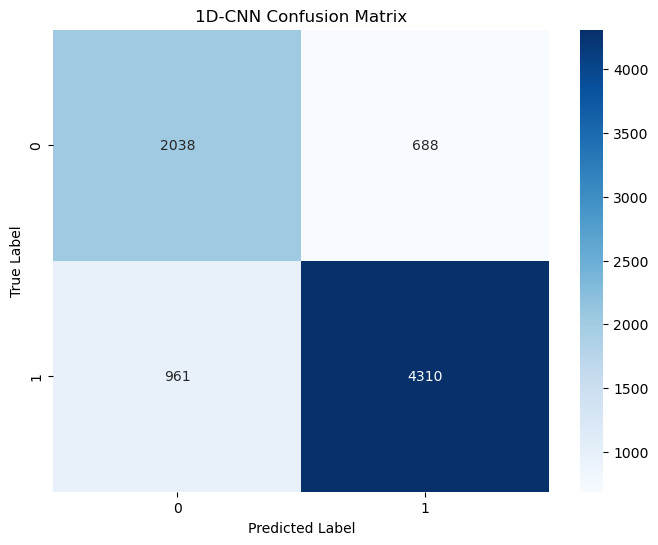

In [127]:
# --- 10. Make Predictions & Generate Reports ---
print("\n生成预测和评估报告...")
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Classification Report
print("Classification Report:")
try:
    target_names = [str(c) for c in sorted(np.unique(y_test))]
    print(classification_report(y_test, y_pred, target_names=target_names))
except Exception as e:
    print(f"生成 classification report 时出错: {e}")
    print("Classification Report (无 target_names):")
    print(classification_report(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('1D-CNN Confusion Matrix')
plt.show()


绘制训练历史...


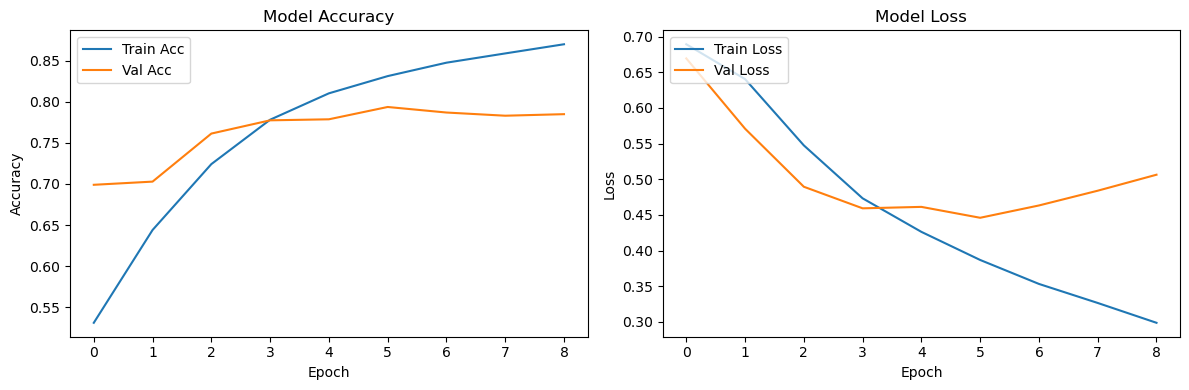


脚本执行完毕。


In [128]:
# --- Optional: Plot Training History ---
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

print("\n绘制训练历史...")
plot_history(history)

print("\n脚本执行完毕。")